In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import activations, optimizers
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import datetime

In [2]:
data = pd.read_csv('dataset/eth.csv')
data.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,31.Oct.17,307.38,310.55,305.88,305.88,"369,583,008.00","29,331,517,440.00"
1,1.Nov.17,305.76,306.40,290.58,291.69,"553,864,000.00","29,183,592,448.00"
2,2.Nov.17,290.73,293.91,281.17,287.43,"904,900,992.00","27,754,237,952.00"
3,3.Nov.17,288.50,308.31,287.69,305.71,"646,339,968.00","27,547,410,432.00"
4,4.Nov.17,305.48,305.48,295.80,300.47,"416,479,008.00","29,175,347,200.00"


In [3]:
open_prices = data['Open'].values
high_prices = data['High'].values
low_prices = data['Low'].values
close_prices = data['Close'].values
volumes = data['Volume'].values
market_caps = data['Market Cap'].values
mid_prices = (high_prices + low_prices) / 2

In [4]:
seq_len = 50
sequence_length = seq_len + 1

open_prices_w = []
mid_prices_w = []
high_prices_w= []
low_prices_w = []
close_prices_w = []
volumes_w = []
for index in range(len(open_prices) - sequence_length):
    open_prices_w.append(open_prices[index: index + sequence_length])
    mid_prices_w.append(mid_prices[index: index+sequence_length])
    high_prices_w.append(high_prices[index:index+sequence_length])
    low_prices_w.append(low_prices[index:index+sequence_length])
    close_prices_w.append(close_prices[index:index+sequence_length])
    volumes_w.append(volumes[index:index+sequence_length])

#

In [5]:
def normalize_windows(data):
    normalized_data = []
    for window in data:
        normalized_window = [((float(str(p).replace(',','')) / float(str(window[0]).replace(',',''))) - 1) for p in window]
        normalized_data.append(normalized_window)
    return np.array(normalized_data)

open_prices_w_normal = normalize_windows(open_prices_w)
mid_prices_w_normal = normalize_windows(mid_prices_w)
high_prices_w_normal = normalize_windows(high_prices_w)
low_prices_w_normal = normalize_windows(low_prices_w)
close_prices_w_normal = normalize_windows(close_prices_w)
volumes_w_normal = normalize_windows(volumes_w)

In [6]:
print(open_prices_w_normal[0])

[ 0.00000000e+00 -5.27034940e-03 -5.41674800e-02 -6.14223437e-02
 -6.18127399e-03 -2.38792374e-02 -3.56236580e-02 -2.86615915e-02
 -4.26507906e-02  4.09916065e-03  4.32363849e-02 -2.85965255e-02
  2.37816384e-02 -1.17118876e-03  3.05159737e-02  9.94859783e-02
  8.47810528e-02  7.41427549e-02  8.00312317e-02  1.30197150e-01
  1.51961741e-01  1.95393324e-01  1.72197280e-01  2.40939554e-01
  3.41987117e-01  5.47530744e-01  5.15941180e-01  5.34029540e-01
  5.63276726e-01  5.39722819e-01  4.02856399e-01  4.48402629e-01
  5.18804086e-01  5.08556185e-01  5.16201444e-01  5.29995445e-01
  5.04977552e-01  3.87110417e-01  4.15153881e-01  4.87865183e-01
  5.38128701e-01  4.32624113e-01  6.99167155e-01  1.09808706e+00
  1.27923092e+00  1.26553452e+00  1.23238337e+00  1.26507906e+00
  1.34800573e+00  1.58279654e+00  1.69217256e+00]


In [7]:
print(mid_prices_w_normal[0])

[ 0.         -0.03155265 -0.0670798  -0.03314245 -0.024577   -0.03234755
 -0.0280486  -0.03377512 -0.00751099  0.03257466  0.00459095  0.00196292
  0.00199536  0.03083886  0.06571711  0.08807164  0.07030806  0.07470435
  0.09876223  0.16157552  0.17682462  0.17314212  0.20300764  0.30045585
  0.43362588  0.53503236  0.49948899  0.56040426  0.53923398  0.53688172
  0.40606395  0.46151226  0.5133754   0.51624678  0.50558863  0.51066626
  0.43231186  0.38833282  0.44125043  0.55800334  0.46375095  0.55097902
  0.88473955  1.18320004  1.30052074  1.1384261   1.26981166  1.32316727
  1.42227017  1.70473533  1.59731032]


In [8]:
# split train and test data
# row 인덱스를 구한다.
row_idx = int(round(open_prices_w_normal.shape[0] * 0.9))
#row_idx = int(round(result.shape[0] * 0.9))
# 0~row_idx 까지의 데이터를 추출한다.
train = np.dstack(
    (open_prices_w_normal[:row_idx, :],
     mid_prices_w_normal[:row_idx,:],
     high_prices_w_normal[:row_idx,:],
     low_prices_w_normal[:row_idx,:],
     close_prices_w_normal[:row_idx,:],
     volumes_w_normal[:row_idx,:],)
)

test = np.dstack(
    (open_prices_w_normal[row_idx:, :],
     mid_prices_w_normal[row_idx:,:],
     high_prices_w_normal[row_idx:,:],
     low_prices_w_normal[row_idx:, :],
     close_prices_w_normal[row_idx:, :],
     volumes_w_normal[row_idx:, :],
     )
)

# 값을 섞는다.
#np.random.shuffle(train)



In [9]:
# train에서 마지막 결과값을 제외하고, 50개를 x_train에 담는다.
x_train = train[:,:-1, :]
# x_train의 차원을 x, y => x, y, 1 로 변경한다. 이유는 아직 모름
# x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# train의 51번째 데이터를 예상 결과 값으로 저장한다.
y_train = train[:,-1, :]

x_test = test[:, :-1, :]
#x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = test[:, -1,:]

open_prices_w_normal.shape,x_train.shape, x_test.shape

((314, 51), (283, 50, 6), (31, 50, 6))

In [10]:
#x_train

In [11]:
model = Sequential()

model.add(LSTM(128, return_sequences=True, input_shape=(50, 6)))

model.add(LSTM(64, return_sequences=False))

# softmax, elu, selu, softplus, softsign, relu, tanh, sigmoid, hard_sigmoid, exponential, linear
model.add(Dense(1, activation='linear'))
# rmsprop, sgd, Adgrad, Adadelta, Adam, Adamax, Nadam
model.compile(loss='mse', optimizer='rmsprop')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 128)           69120     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 118,593
Trainable params: 118,593
Non-trainable params: 0
_________________________________________________________________


In [12]:
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=200,
    callbacks=[
        TensorBoard(log_dir='logs/%s' % (start_time)),
        ModelCheckpoint('./models/%s_eth.h5' % (start_time), monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='auto')
])

Epoch 1/200
29/29 [==============================] - 3s 49ms/step - loss: 0.6764 - val_loss: 0.0268

Epoch 00001: val_loss improved from inf to 0.02683, saving model to ./models/2021_03_02_15_12_02_eth.h5
Epoch 2/200
29/29 [==============================] - 1s 23ms/step - loss: 0.3142 - val_loss: 0.0282

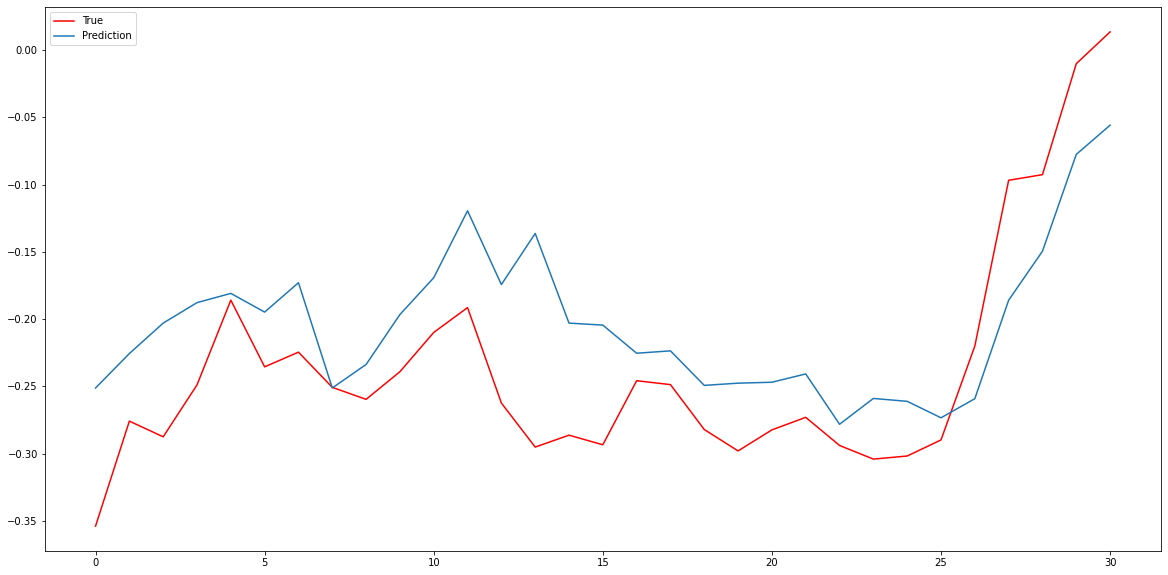

In [13]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test[:,1], label='True',color='red')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

In [14]:
print(y_test)

[[-0.39387063 -0.35391307 -0.36245743 -0.34439758 -0.30684062  0.29970578]
 [-0.30793394 -0.27586153 -0.29100102 -0.25945736 -0.2771103  -0.01385747]
 [-0.27305031 -0.28753535 -0.28740984 -0.28766478 -0.27787339 -0.0171771 ]
 [-0.27828612 -0.24893176 -0.28552001 -0.20738427 -0.20705061 -0.11941023]
 [-0.20937947 -0.18592658 -0.20920487 -0.15974867 -0.20951493 -0.21232547]
 [-0.21377367 -0.23551078 -0.25508087 -0.21430101 -0.21299051 -0.21225674]
 [-0.2138714  -0.22459053 -0.23505763 -0.21346955 -0.2098594  -0.00363175]
 [-0.20901696 -0.2507622  -0.27909036 -0.21959283 -0.28698572 -0.24575286]
 [-0.28836138 -0.25968699 -0.29358714 -0.2217763  -0.23559041 -0.16640401]
 [-0.23390943 -0.23912571 -0.24855096 -0.22919027 -0.23790845  0.01576755]
 [-0.23780609 -0.20993978 -0.24381509 -0.17224233 -0.1689268  -0.00612538]
 [-0.16723375 -0.19147148 -0.20372766 -0.17864852 -0.19922679  0.18891523]
 [-0.19987942 -0.26240466 -0.24162157 -0.28573585 -0.30161421  0.43773795]
 [-0.30557498 -0.29516563